In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
import squarify
import seaborn as sns

## Calling the Saved Dataset

In [2]:
course_dataset = pd.read_csv("data/courseData.csv", encoding= 'unicode_escape')
course_dataset.head()

,Unnamed: 0,sr_,degree_1,degree_1_specializations,campus,key_skills,key_skills_str
0,0,1001,B.E.,Mechanical,MITCOE,['CATIA'],CATIA
1,1,1002,B.E.,Mechanical,MITCOE,['CATIA'],CATIA
2,2,1003,B.E.,Mechanical,MITAOE,['CATIA'],CATIA
3,3,1004,B.E.,Mechanical,MITCOE,['CATIA'],CATIA
4,4,1005,B.E.,Mechanical,MITCOE,['CATIA'],CATIA


In [3]:
user_dataset = pd.read_csv("data/userData.csv", encoding= 'unicode_escape')
user_dataset.head()

,Unnamed: 0,userid,degree_1,degree_1_specializations,known_languages,key_skills,career_objective,key_skills_str
0,0,1001,B.E.,Computer Science & Engineering,"['English', ' Marathi', ' Hindi']","['C', ' Java', ' Keras', ' Flask', ' Deep Lear...",Computer Engineering student with good technic...,"C, Java, Keras, Flask, Deep Learning, Sel..."
1,1,1002,B.E.,Computer Science & Engineering,['Hindi English'],"['Java', ' Neural Networks', ' AI', ' Python',...",Interested in working under company offering A...,"Java, Neural Networks, AI, Python, Html5, ..."
2,2,1003,B.E.,Computer Science & Engineering,['Missing'],['Missing'],Missing,Missing
3,3,1004,B.E.,Computer Science & Engineering,"['English', ' Hindi', ' Marathi', ' Marwari']","['XML', ' C', ' Java', ' Data Structures', ' P...",Currently a final year student of Computer Eng...,"XML, C, Java, Data Structures, Python, Mo..."
4,4,1005,B.E.,Computer Science & Engineering,"['English', 'Hindi ', 'Kashmiri ', ' Urdu']","['XML', ' Word', ' Data Structures', ' Communi...",To have a growth oriented and challenging care...,"XML, Word, Data Structures, Communication, ..."


## Clustering Technique

### Course Dataset - Key Skills

#### Trying different k values 

In [4]:
def tokenize(text):
    stemmer=SnowballStemmer('english')
    return [stemmer.stem(word) for word in word_tokenize(text.lower())]

In [5]:
vectorizer= TfidfVectorizer(stop_words=set([","]),tokenizer=tokenize, max_features=1000)
X=vectorizer.fit_transform(course_dataset["key_skills_str"])

In [6]:
#k_cluster_range is the values of k we will loop through (from 1 to 30 seems common)
k_cluster_range = range(1,30)
inertia = np.zeros(len(k_cluster_range)) #sum of squares errors

for i in range(len(k_cluster_range)):
    kmeans = KMeans(n_clusters=i+1, init='k-means++', random_state=1234).fit(X)
    inertia[i] = kmeans.inertia_
    
course_dataset['cluster']=kmeans.labels_

Text(6, 7700, "Let's try k=6")

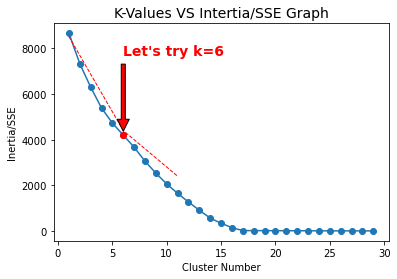

In [7]:
#plotting the kvalues vs inertia graph
plt.plot(k_cluster_range, inertia, 'o-')
plt.xlabel('Cluster Number')
plt.ylabel('Inertia/SSE')
plt.title('K-Values VS Intertia/SSE Graph', size=14)
#save the plot
#plt.savefig('elbow_method.png')

#plotting the red line and arrow
plt.plot([6], [inertia[5]], 'o--', color='red')
plt.plot([1,6,11], [8520, 4400,2400], '--', color='red', linewidth=1)
plt.annotate("Let's try k=6", xy=(6, inertia[5]), xytext=(6,7700),
             size=14, weight='bold', color='red',
             arrowprops=dict(facecolor='red', shrink=0.05))

Explained variance is 0.3122.


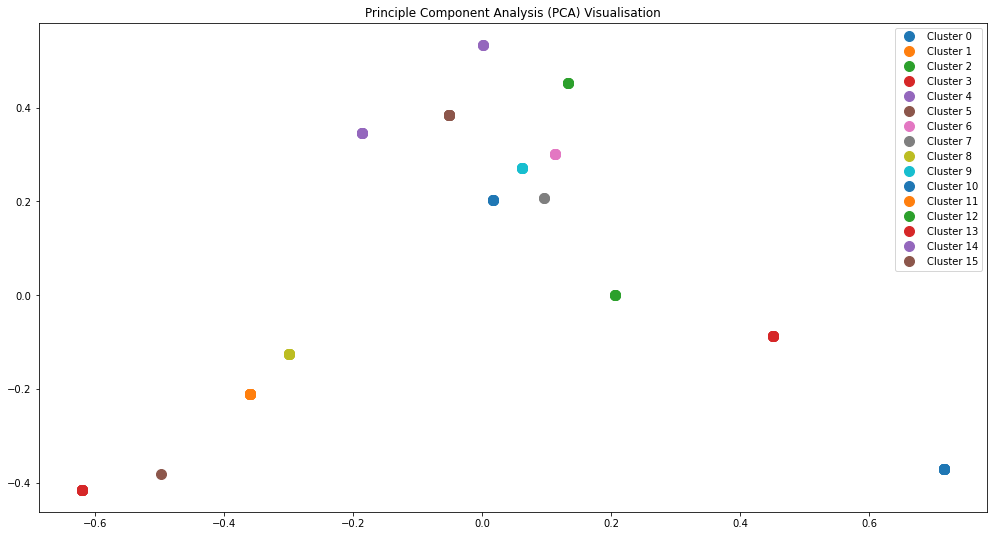

In [9]:
pca=PCA(n_components=2)
X_2d=pca.fit_transform(X.todense())

print('Explained variance is {}.'.format(round(pca.explained_variance_ratio_.sum(), 4)))

df = pd.DataFrame(dict(x=X_2d[:,0], y=X_2d[:,1], label=course_dataset['cluster'])) 
df_sample=df.sample(100)
groups = df_sample.groupby('label')

fig, ax = plt.subplots(figsize=(17, 9)) 
for cluster_name in np.arange(len(df_sample['label'].unique())):
    temp=df_sample[df_sample['label']==cluster_name]
    ax.plot(temp.x, temp.y, marker='o', linestyle='', ms=10, 
        label='Cluster '+str(cluster_name))
ax.legend(numpoints=1) 
plt.title('Principle Component Analysis (PCA) Visualisation')
plt.show()

### Course Dataset - Degree1, Degree1 Specializations & Key Skills

In [10]:
comb_frame = course_dataset.degree_1.str.cat(" " + course_dataset.degree_1_specializations.str.cat(" " + course_dataset.key_skills_str))
comb_frame = comb_frame.replace({"[^A-Za-z0-9 ]+": ""}, regex=True)

vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(comb_frame)
X.shape #(10,000 x 69)

(10000, 69)

In [11]:
k_cluster_range = range(1,31)
inertia = np.zeros(len(k_cluster_range)) #sum of squares errors

for i in range(len(k_cluster_range)):
    kmeans = KMeans(n_clusters=i+1, init='k-means++', random_state=1234, max_iter=100).fit(X)
    comb_frame["clusters"] = kmeans.labels_
    inertia[i] = kmeans.inertia_

Text(0.5, 1.0, 'K-Values VS Intertia/SSE Graph')

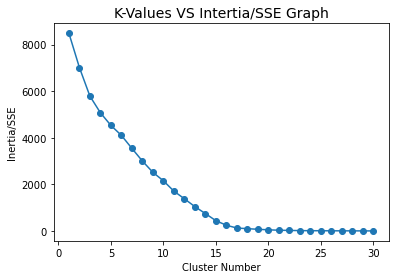

In [12]:
#plotting the kvalues vs inertia graph
plt.plot(k_cluster_range, inertia, 'o-')
plt.xlabel('Cluster Number')
plt.ylabel('Inertia/SSE')
plt.title('K-Values VS Intertia/SSE Graph', size=14)
#save the plot
#plt.savefig('elbow_method.png')

Explained variance is 0.3457.


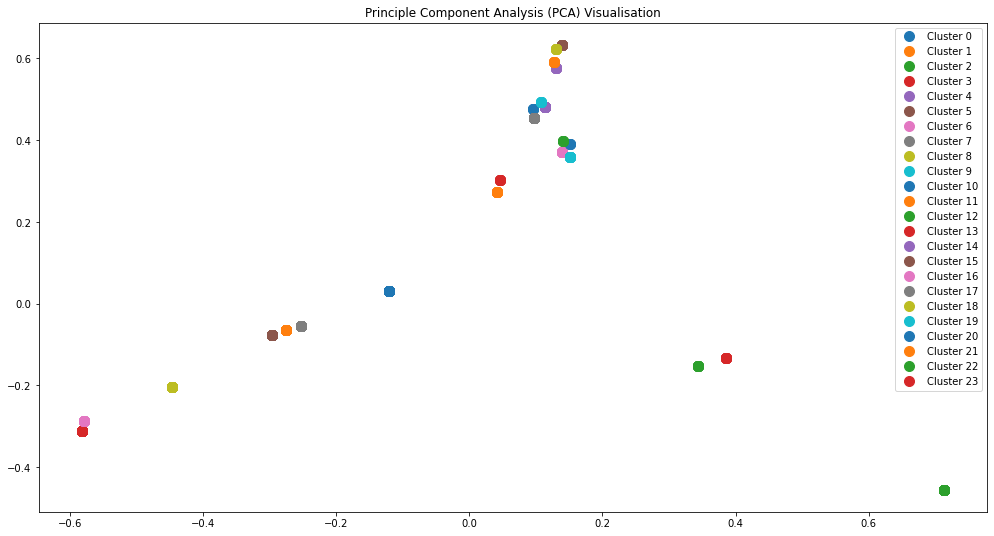

In [13]:
pca=PCA(n_components=2)
X_2d=pca.fit_transform(X.todense())

print('Explained variance is {}.'.format(round(pca.explained_variance_ratio_.sum(), 4)))

df = pd.DataFrame(dict(x=X_2d[:,0], y=X_2d[:,1], label=comb_frame["clusters"])) 
df_sample=df.sample(500)
groups = df_sample.groupby('label')

fig, ax = plt.subplots(figsize=(17, 9)) 
for cluster_name in np.arange(len(df_sample['label'].unique())):
    temp=df_sample[df_sample['label']==cluster_name]
    ax.plot(temp.x, temp.y, marker='o', linestyle='', ms=10, 
        label='Cluster '+str(cluster_name))
ax.legend(numpoints=1) 
plt.title('Principle Component Analysis (PCA) Visualisation')
plt.show()

#### The two different clusters we made seem identical even though the first is based solely on key skills and the second is a combination of key skills, degree specialization and degree type 

### User Dataset -  Key Skills

#### Trying different k values 

In [14]:
vectorizer = TfidfVectorizer(stop_words=set([",", "--", "-", "#", "&", "-c-"]),tokenizer=tokenize, max_features=1000)
X = vectorizer.fit_transform(user_dataset["key_skills_str"].values.astype('U'))

In [15]:
#k_cluster_range is the values of k we will loop through (from 1 to 30 seems common)
#try using smaller ranges to see that clustering is done correctly
k_cluster_range = range(1,5)
inertia = np.zeros(len(k_cluster_range)) #sum of squares errors

for i in range(len(k_cluster_range)):
    kmeans = KMeans(n_clusters=i+1, init='k-means++', random_state=1234).fit(X)
    inertia[i] = kmeans.inertia_
    
user_dataset['cluster']=kmeans.labels_

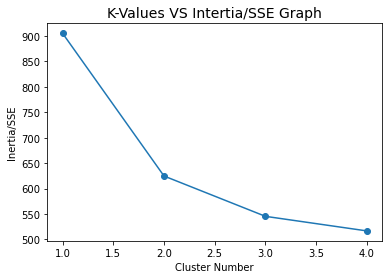

In [16]:
#plotting the kvalues vs inertia graph
plt.plot(k_cluster_range, inertia, 'o-')
plt.xlabel('Cluster Number')
plt.ylabel('Inertia/SSE')
plt.title('K-Values VS Intertia/SSE Graph', size=14)
plt.show()
#save the plot
#plt.savefig('elbow_method.png')

Explained variance is 0.4047.


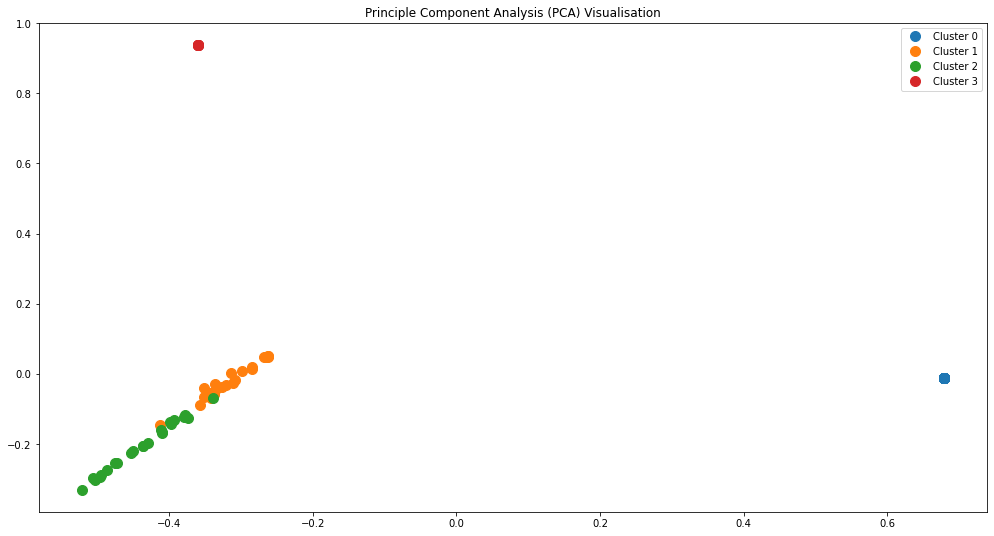

In [17]:
pca=PCA(n_components=2)
X_2d=pca.fit_transform(X.todense())

print('Explained variance is {}.'.format(round(pca.explained_variance_ratio_.sum(), 4)))

df = pd.DataFrame(dict(x=X_2d[:,0], y=X_2d[:,1], label=user_dataset['cluster'])) 
df_sample=df.sample(100)
groups = df_sample.groupby('label')

fig, ax = plt.subplots(figsize=(17, 9)) 
for cluster_name in np.arange(len(df_sample['label'].unique())):
    temp=df_sample[df_sample['label']==cluster_name]
    ax.plot(temp.x, temp.y, marker='o', linestyle='', ms=10, 
        label='Cluster '+str(cluster_name))
ax.legend(numpoints=1) 
plt.title('Principle Component Analysis (PCA) Visualisation')
plt.show()

### User Dataset -  Career Objective

#### Trying different k values 

In [18]:
vectorizer= TfidfVectorizer(stop_words=set([",", "--", "-", "#", "&", "-c-"]),tokenizer=tokenize, max_features=1000)
X=vectorizer.fit_transform(user_dataset["career_objective"].values.astype('U'))

In [19]:
#k_cluster_range is the values of k we will loop through (from 1 to 30 seems common)
k_cluster_range = range(1,30)
inertia = np.zeros(len(k_cluster_range)) #sum of squares errors

for i in range(len(k_cluster_range)):
    kmeans = KMeans(n_clusters=i+1, init='k-means++', random_state=1234).fit(X)
    inertia[i] = kmeans.inertia_
    
user_dataset['cluster']=kmeans.labels_

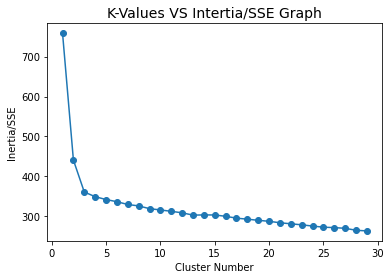

In [20]:
#plotting the kvalues vs inertia graph
plt.plot(k_cluster_range, inertia, 'o-')
plt.xlabel('Cluster Number')
plt.ylabel('Inertia/SSE')
plt.title('K-Values VS Intertia/SSE Graph', size=14)
plt.show()
#save the plot
#plt.savefig('elbow_method.png')

Explained variance is 0.527.


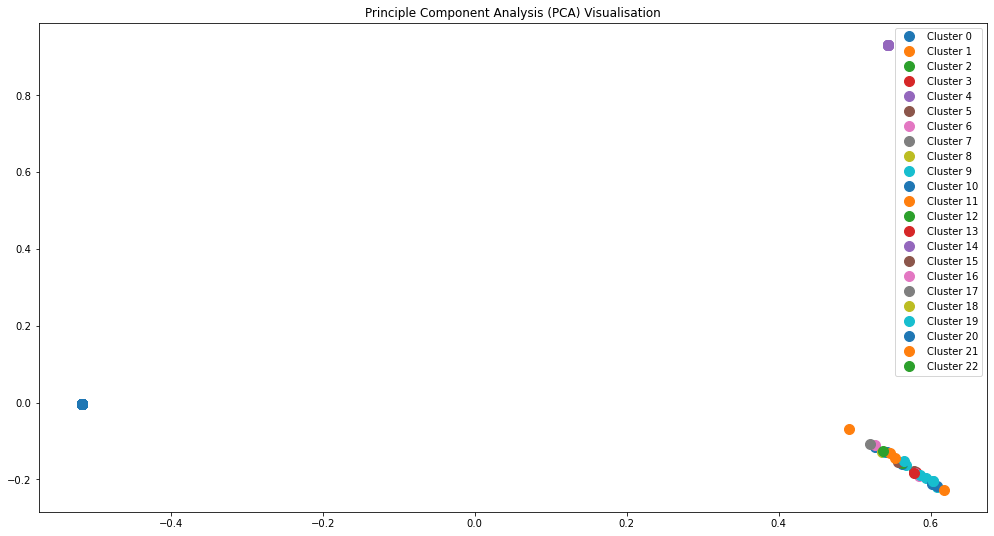

In [21]:
pca=PCA(n_components=2)
X_2d=pca.fit_transform(X.todense())

print('Explained variance is {}.'.format(round(pca.explained_variance_ratio_.sum(), 4)))

df = pd.DataFrame(dict(x=X_2d[:,0], y=X_2d[:,1], label=user_dataset['cluster'])) 
df_sample=df.sample(100)
groups = df_sample.groupby('label')

fig, ax = plt.subplots(figsize=(17, 9)) 
for cluster_name in np.arange(len(df_sample['label'].unique())):
    temp=df_sample[df_sample['label']==cluster_name]
    ax.plot(temp.x, temp.y, marker='o', linestyle='', ms=10, 
        label='Cluster '+str(cluster_name))
ax.legend(numpoints=1) 
plt.title('Principle Component Analysis (PCA) Visualisation')
plt.show()

### User Dataset -  Degree1 Specializations, Career Objective & Key Skills

In [22]:
comb_user_frame = user_dataset.degree_1_specializations.str.cat(" " + user_dataset.career_objective.str.cat(" " + user_dataset.key_skills_str))
comb_user_frame = comb_user_frame.replace({"[^A-Za-z0-9 ]+": ""}, regex=True)

vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(comb_user_frame.values.astype('U'))
X.shape #(10,000 x 69)

(1097, 1697)

In [23]:
k_cluster_range = range(1,31)
inertia = np.zeros(len(k_cluster_range)) #sum of squares errors

for i in range(len(k_cluster_range)):
    kmeans = KMeans(n_clusters=i+1, init='k-means++', random_state=1234, max_iter=100).fit(X)
    comb_user_frame["clusters"] = kmeans.labels_
    inertia[i] = kmeans.inertia_

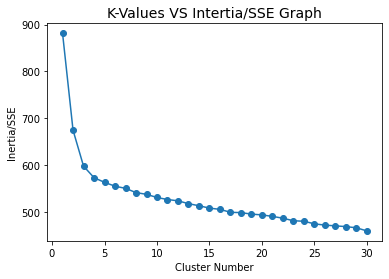

In [24]:
#plotting the kvalues vs inertia graph
plt.plot(k_cluster_range, inertia, 'o-')
plt.xlabel('Cluster Number')
plt.ylabel('Inertia/SSE')
plt.title('K-Values VS Intertia/SSE Graph', size=14)
plt.show()
#save the plot
#plt.savefig('elbow_method.png')

Explained variance is 0.3351.


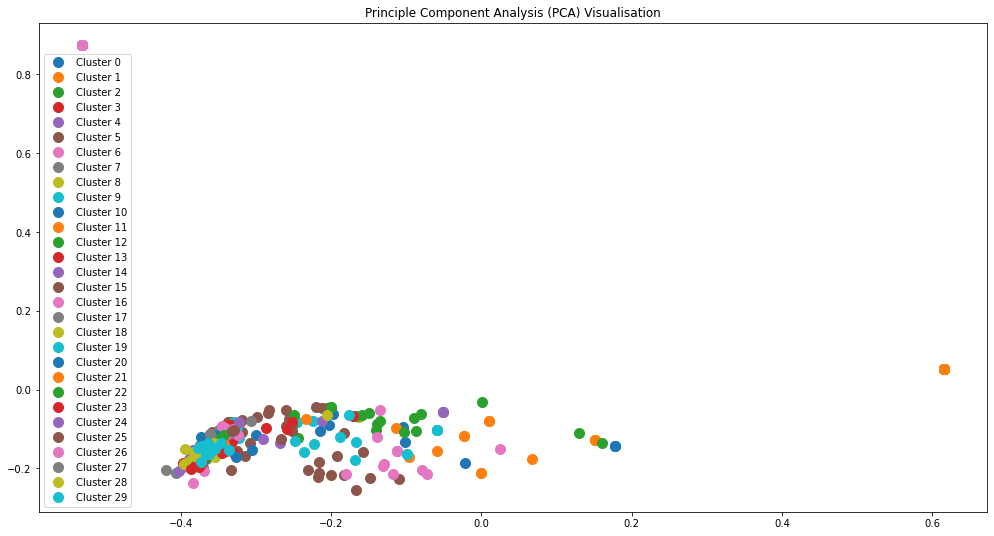

In [25]:
pca=PCA(n_components=2)
X_2d=pca.fit_transform(X.todense())

print('Explained variance is {}.'.format(round(pca.explained_variance_ratio_.sum(), 4)))

df = pd.DataFrame(dict(x=X_2d[:,0], y=X_2d[:,1], label=comb_user_frame["clusters"])) 
df_sample=df.sample(500)
groups = df_sample.groupby('label')

fig, ax = plt.subplots(figsize=(17, 9)) 
for cluster_name in np.arange(len(df_sample['label'].unique())):
    temp=df_sample[df_sample['label']==cluster_name]
    ax.plot(temp.x, temp.y, marker='o', linestyle='', ms=10, 
        label='Cluster '+str(cluster_name))
ax.legend(numpoints=1) 
plt.title('Principle Component Analysis (PCA) Visualisation')
plt.show()

## Collaborative Filtering

## Content Based Filtering

In [26]:
#https://github.com/ry05/couReco/blob/master/recommender.py